# Bayesian Logistic Regression

---

<b><div style="text-align: right">[TOTAL POINTS: 20]</div></b>

In previous reads of this unit, you learned bayesian approach for parameter estimation on linear regression model and MLE for logistic regression. In this assignment, your task is to build a __bayesian logistic regression model__ on binary classification problem. Don't fret, all the theory related to bayesian parameter estimation for logistic regression is present alongside the code blocks. Let's get started.

## Learning Objective

By the end of this assignment, student should be able to:

- Develop theoritical understanding of bayesian logistic regression.

- Implement functions to compute negative log posterior, normalized gradient and hessian matrix, required for computing bayesian logistic regression.

- Finally, use above mentioned base functions to implement bayesian logistic regression model.

## Basic Imports and Settings

In [1]:
# Importing required libraries for data generation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# MPL settings
plt.rcParams.update({
    'figure.figsize':(12,8),
    'font.size': 16,
})

# Defining random state of variable
RANDOM_STATE=100

## Dataset

### Exercise 1: Generating Synthetic Dataset

<b><div style="text-align: right">[POINTS: UNGRADED]</div></b>

The logistic regression model created in this assignment is trained and tested on a _synthetic classification dataset_. Your first task is regarding the generation of synthetic dataset.

__Task:__

1. Import ```sklearn.datasets.make_classification``` method. 

2. Generate a synthetic binary classification dataset using ```sklearn's make_classifcation``` method. Store the independent features in variable ```X_data``` and target features in ```y_data```.

  The characteristics of the data or parameter passed are as:
  - Number of samples = 300
  - Number of features = 2
  - Number of informative features = 2
  - Number of redundant features = 0
  - ```shift``` = 50
  - ```class_sep``` = 1.2

NOTE: Use the ```RANDOM_STATE``` constant as random_state when generating the synthetic data in ```make_classification``` method.

3. Next, Store the dataset in a Pandas DataFrame named ```syn_df```. Each column must be a feature or target value. The column names must be ```feature_1, feature_2,``` and ```target``` for independent features and target, respectively.

The ```X_data, y_data``` and ```syn_df``` must be of shape (300,2), (300,) and (300,3) respectively, with the number of samples ($n$)=300 number of features ($m$) = 2.

In [2]:
# Variables to store the dataset
X_data, y_data, syn_df = None, None, None

In [3]:
### Ex-1-Task-1

### BEGIN SOLUTION
# your code here
from sklearn.datasets import make_classification
X_data, y_data = make_classification(n_samples =300, n_features =2, n_informative =2,n_redundant=0,shift=50, class_sep =1.2, random_state = RANDOM_STATE)
column_values = ['feature_1', 'feature_2', 'target']
syn_df = pd.DataFrame(data = np.concatenate((X_data, y_data.reshape(300,1)), axis=1), 
                  columns = column_values)
# raise NotImplementedError
### END SOLUTION

In [4]:
assert X_data is not None and y_data is not None and syn_df is not None,\
'The feature matrix and/or target vector and/or dataframe is empty '

assert X_data.shape == (300,2), 'Wrong dimension of input feature matrix'
assert y_data.shape == (300,), 'Wrong dimension of target vector'
assert syn_df.shape == (300,3), 'Wrong dimension of dataframe'


## Part 1: EDA and preprocessing

Starting with the EDA, we require to know about the number of samples, features/target and type. Using ```.info()``` property display all the above mentioned properties of the dataset. 

In [5]:
# Information regarding the synthetic data
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  300 non-null    float64
 1   feature_2  300 non-null    float64
 2   target     300 non-null    float64
dtypes: float64(3)
memory usage: 7.2 KB


As you can see synthetic dataset generated contains only two numeric feature. Which of the following should be conducted for this data?

a. categorical feature transformation.

b. feature selection. so performing 

<details>    
<summary>
    <font size="3" color="darkgreen"><b> Answer</b></font>
</summary>
<p>     
<ul>
</ul>
</p>

- None of them. No proper reason to conduct categorical variable transformation on an all numeric dataset. Also with only two features, feature selection process is unneccesary. 

Next, let's look if the data is imbalanced.

In [6]:
# Checking count of samples with respect to class
syn_df['target'].value_counts()

1.0    151
0.0    149
Name: target, dtype: int64

As expected the synthetic dataset generated using sklearn is __balanced__. Which of the following evaluation metric can be used for this classification problem?

a. Accuracy.

b. F1-score.

<details>    
<summary>
    <font size="3" color="darkgreen"><b> Answer</b></font>
</summary>
<p>     
<ul>
</ul>
</p>

- Both of them. As there is no imbalance in the data, both accuracy and f1-score evaluates. (No misleading values.)

Next, let's look at the distribution of the features.

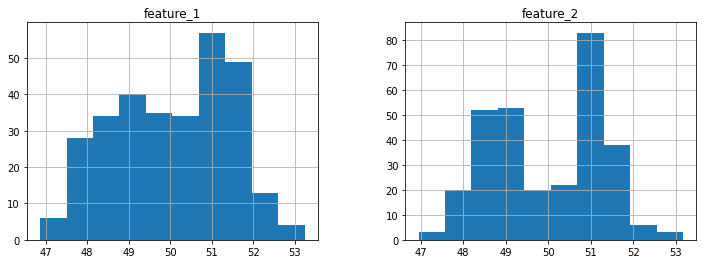

In [7]:
# Distribution of the features

syn_df[['feature_1', 'feature_2']].hist(figsize=(12,4), bins='auto')
plt.show()

Normally distributed features results in better performance of logistic regression model. Mathematical transformation techniques are viable for changing the feature distribution. However, let's scatterplot the dataset and to check if the transformation is necessary.

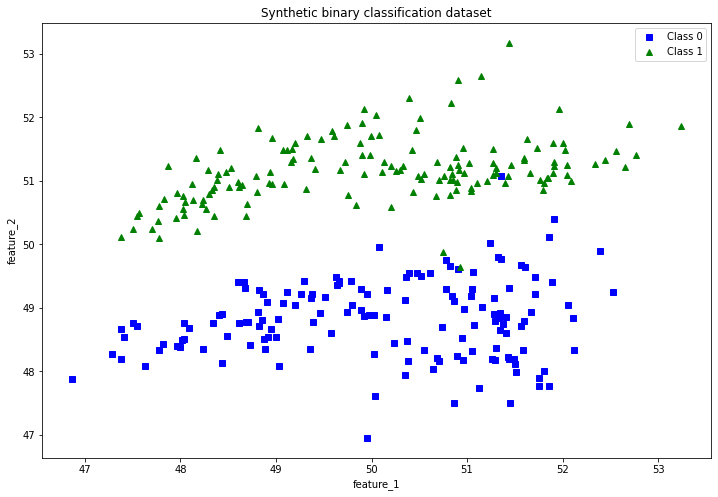

In [8]:
# Visualization
plt.figure(figsize=(12,8))
# Plotting class 0 data
plt.plot(X_data[:,0][y_data==0], X_data[:,1][y_data==0], 'bs', label='Class 0')

# Plotting class 1 data
plt.plot(X_data[:,0][y_data==1], X_data[:,1][y_data==1], 'g^', label='Class 1')

# labeling plot
plt.xlabel(syn_df.columns[0])
plt.ylabel(syn_df.columns[1])
plt.title('Synthetic binary classification dataset')
plt.legend()
plt.show()

From the above visualization, we find the dataset being __separable by a linear line__, i.e. separable using logistic regression model. As the dataset is already separable by logistic regression model, mathematical transformation isn't necessary.

However, We require converting the data into correct dimension. To be exact, padded input feature matrix,
$
 \it{X} = 
\begin{pmatrix}
\mathbf{x}_1^T  \\ 
\mathbf{x}_2^T \\
.\\. \\.\\
\mathbf{x}_n^T  \\
\end{pmatrix} =
 \begin{pmatrix}
  1 & x_{1,1} & \cdots & x_{1,m} \\
  1 & x_{2,1} & \cdots & x_{2,m} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  1 & x_{n,1} & \cdots & x_{n,m}
 \end{pmatrix}_{\text{(n $\times$ (m+1))}}$, and target vector
$\mathbf{y}=\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix}_{\text{(n $\times$ 1)}}$  for effective vector computation hypothesis for logistic regression model.

Also, though this synthetic data has feature magnitudes around same range, you will be conducting feature scaling. Discussion on why the features are scaled is present in the last section of this assignment.

### Exercise 2: Feature scaling and Conversion the data into proper dimension plus train-test split

<b><div style="text-align: right">[POINTS: 2]</div></b>

Logistic regression is prone to feature magnitude, scaling the features is essential. In this exercise you are doing the following:

- __Tasks__

 __[Task 1: Points: 1]__
 1. Scale the feature matrix, store in ```X_mat_norm```. Use ```sklearn.preprocessing.MinMaxScaler``` for scaling.
 
 __[Task 2: Points: 1]__
 2. Pad the feature matrix ```X_mat_norm``` with column of ones, and store in ```X_mat_pad```. Reshape the dimension target vector ```y_data``` and store in ```y_vec```. 
 3. Finally, split the dataset with test_size = 0.2.

In [9]:
## Variable to store the scaled feature vector.
X_mat_norm = None

## Variables to store the matrix and vector.
X_mat_pad, y_vec = None, None

## Variable to store train test data
X_train, X_test, y_train, y_test = None, None, None, None

In [10]:
### Ex-2-Task-1

### BEGIN SOLUTION
# your code here
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler()
scaler.fit(X_data)
X_mat_norm = scaler.transform(X_data)
# raise NotImplementedError
### END SOLUTION

In [11]:
assert X_mat_norm is not None, 'X_mat_norm is empty'


In [12]:
### Ex-2-Task-2

### BEGIN SOLUTION
# your code here
X_mat_pad, y_vec = np.insert(X_mat_norm, 0, 1, axis=1), y_data.reshape(300,1)
X_train, X_test, y_train, y_test = train_test_split(X_mat_pad, y_vec, test_size=0.2, random_state=RANDOM_STATE)
# raise NotImplementedError
### END SOLUTION

In [13]:
assert X_mat_pad is not None and y_vec is not None , 'X_mat_pad or y_vec is empty'
assert X_mat_pad.shape == (300,3) and y_vec.shape == (300,1), 'Wrong shape'


## Changes after scaling and train_test_split

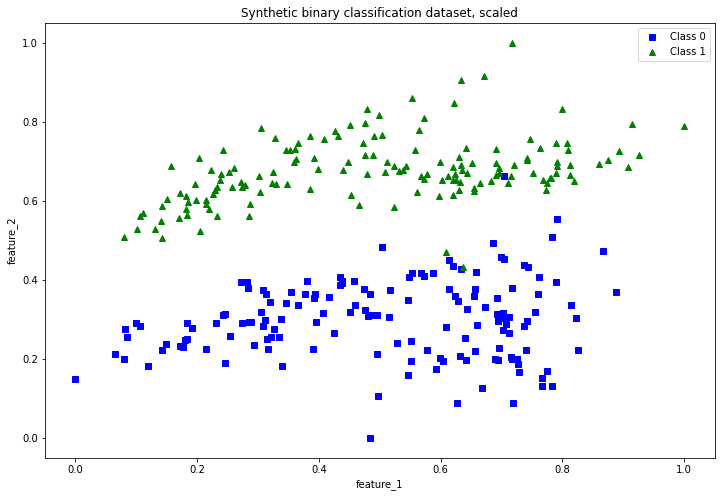

In [14]:
# Visualization after scaling

plt.figure(figsize=(12,8))
# Plotting class 0 data
plt.plot(X_mat_pad[:,1][y_data==0], X_mat_pad[:,2][y_data==0], 'bs', label='Class 0')

# Plotting class 1 data
plt.plot(X_mat_pad[:,1][y_data==1], X_mat_pad[:,2][y_data==1], 'g^', label='Class 1')

# labeling plot
plt.xlabel(syn_df.columns[0])
plt.ylabel(syn_df.columns[1])
plt.title('Synthetic binary classification dataset, scaled')
plt.legend()
plt.show()

After minmax scaling, notice that range of feature value is between 0 and 1. However, the shape of data clusters hasn't changed. Next, let's see the class label count after train test split for both training and test set.

Text(0.5, 1.0, 'Count of class in test set')

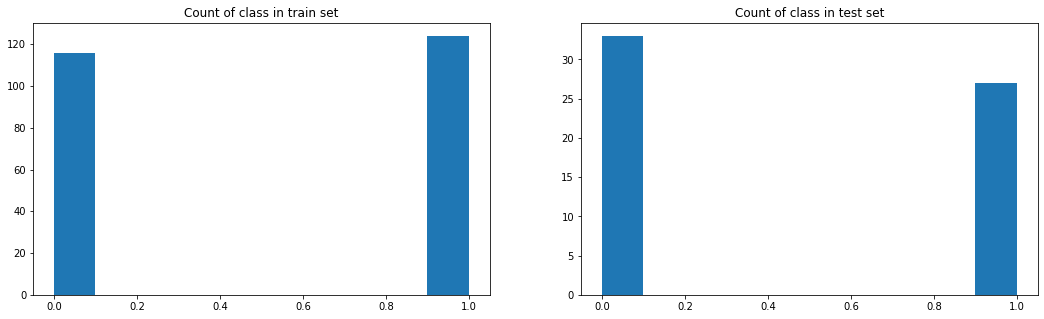

In [15]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.hist(y_train)
plt.title('Count of class in train set')
plt.subplot(122)
plt.hist(y_test)
plt.title('Count of class in test set')

As seen in the histograms - no imbalance of class in either train or test set. Thus, stratified sampling isn't required. This concludes EDA and preprocessing part of the assignment.

## Part 2: Implementation of bayesian logistic regression

This section contains the theory and implemenation portion of bayesian logistic regression model. Your task is to implement multiple functions required for developing bayesian logistic regression model. It's highly advised that you __read the theory portions__ present above the implementation throughly before starting to code.

### Bayesian inference for logistic regression

First, let's assume we have a binary classification dataset given by $\mathcal{D} = \{(\mathbf{x}_i, y_i), i \in \{1, \cdots, n\}\}, y_i \in \{0,1\}$. As a quick review, logistic regression gives the probability of positive class given feature vector computed using __hypothesis function__ as:

$$
\boxed{P(y_i=1|\mathbf{x}_i,\boldsymbol \beta)= h_i = \underbrace{\frac{e^{(\mathbf{x}_i^T\boldsymbol \beta)}}{1+e^{(\mathbf{x}_i^T\boldsymbol \beta)}}}_{\sigma(\mathbf{x})} = \frac{1}{1+e^{-(\mathbf{x}_i^T\boldsymbol \beta)}}} \tag{1}
$$

Where, $\beta$ is the parameter of the model, $y_i$ and $\mathbf{x}_i$ is the $i^{th}$ true target class and covariate vector, and $\sigma(x)$ is the sigmoid function.

Unlike point estimation method such as MLE and MAP, bayesian estimation gives the probability distribution over the parameter $\boldsymbol \beta$, i.e. posterior distribution. Next, for the  computation the posterior distribution we use bayes theorem as:

$$
\boxed{p(\boldsymbol \beta \vert \mathcal{D}) = \frac{p(\mathcal D \vert \boldsymbol \beta ) p(\boldsymbol \beta) }{\underbrace{p(\mathcal D)}_{\text{constant}} }\propto p(\mathcal D \vert \boldsymbol \beta ) p(\boldsymbol \beta)} \tag{2}
$$

Or,

$$
\text{Posterior} = \text{Constant} \times \text{Likelihood} \times \text{Prior}
$$

Where, the constant normalization term, __evidence__ is given as:

$$
\boxed{P(\mathcal{D}) = \int_{\boldsymbol \beta' \in B} p(\mathcal D \vert \boldsymbol \beta' ) p(\boldsymbol \beta') d\boldsymbol \beta'} \tag{3}
$$

Along with that, for prediction of future data points one require computing the __predictive distribution__ $p(y_i \vert \mathcal{D})$, written in the form of marginalization over paramters $\boldsymbol \beta$ as:

$$
\boxed{p(y_i \vert \mathcal D) = \int p(y_i \vert \mathbf{x}_i, \boldsymbol \beta) \ p(\boldsymbol \beta \vert \mathcal D) \ d\boldsymbol \beta} \tag{4}
$$

Unfortunately, __bayesian inference for logistic regression model is intractable__. Precisely, evaluation of posterior distribution requires computing the normalization (evidence) term comprising the likelihood function and prior. Since, the __likelihood function__ $P(\mathbf{y}|\it{X}, \boldsymbol \beta)$ of logistic regression model  given in terms of __bernoulli distribution__ as,

$$
\boxed{p(\mathcal D \vert \boldsymbol \beta ) = p(\mathbf{y} \vert \it{X}, \boldsymbol \beta) =  \prod_{i=1}^n p(y_i \vert \mathbf{x}_i, \boldsymbol \beta)
= \prod_{i=1}^nh_i^{y_i}(1-h_i)^{1-y_i}} \tag{5} 
$$

comprises of product of sigmoid functions (transcendental function) for every data point, there is no closed-form solution for the evidence. Consequently, there's no closed-form solution for posterior distribution and also the predictive function.

Note: The dimension for weight vector is:

$$\boldsymbol \beta = \begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_m 
\end{pmatrix}_{\text{((m+1) $\times$ 1)}},
$$



### Exercise 3: Define functions for calculating sigmoid and hypothesis function

<b><div style="text-align: right">[POINTS: 2]</div></b>

**Task:** 
- Define a lambda function to compute sigmoid value given an input ```x```. Store the function in ```sigmoid```. __[Task 1: Points:1]__
- Define a function named ```calculate_hypothesis``` to compute the hypothesis function of logistic regression model. __[Task 2: Points:1]__

Note: the hypothesis of logistic regression model must be on shape ```(n,1)```.

In [ ]:
# Variable to store sigmoid function
sigmoid = None

In [16]:
### Ex-3-Task-1

### BEGIN SOLUTION
# your code here
sigmoid =  lambda x : 1/(1+np.exp(-x))
# raise NotImplementedError
### END SOLUTION

In [17]:
assert sigmoid is not None, 'Please initialize sigmoid function'


In [18]:
### Ex-3-Task-2
def calculate_hypothesis(input_feat, beta):
    '''
    Computes the hypothesis function of logistic regression model
    
    Parameters
    ----------
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
        
    beta: np.array, shape: (m+1,1)
           weight coefficients vector
        
    Returns
    -------
    hyp: np.array, shape:(n,1)
            hypothesis/predicted value of logistic regression model
    '''
    ### BEGIN SOLUTION
    # your code here
    z =  np.matmul(input_feat, beta)
    hyp = sigmoid(z)
    # raise NotImplementedError
    ### END SOLUTION
    
    return hyp

In [19]:
assert calculate_hypothesis(np.ones((5,2)), np.ones((2,1))).shape == (5,1), 'wrong dimension of the hypothesis vector'


### Laplace Approximation

One way of solving this intractability is using __Laplace Approximation__. Discussing about laplace transformation in-depth is beyond the scope of ML level 2 course. If you are interested, go through the book "Pattern Recognition and Machine Learning" by Christopher M. Bishop, page 213-216.

In short, laplace approximation finds the Gaussian approximation to a probability density function.
Where, 
- The __mean__ is equal to __mode of the pdf or log transformed pdf__, as log transformation is monotonically increasing function.
- The __covariance__ is equal to __inverse of hessian matrix of negative log transformed pdf__.

We use laplace approximation to __find the Gaussian approximation for the posterior distribution__ of logistic regression model and then compute the predictive distribution accordingly.

The first step of bayesian inference of parameters is assumption of the prior distribution.

## Selecting prior distribution

Since, we are finding Gaussian approximation of the posterior distribution, let's assume a __Gaussian prior__ of form:

$$
p(\boldsymbol \beta) \sim \mathcal{N}(\boldsymbol \beta \vert \mathbf{m}_0, \mathbf{S}_0)
$$

The formula being:

$$
\boxed{p(\boldsymbol \beta) = \frac{1}{(2\pi)^{m/2}(|\mathbf{S}_0|)^{1/2}}\exp(-\frac{1}{2}(\boldsymbol \beta-\mathbf{m}_0)^T\mathbf{S}_0^{-1}(\boldsymbol \beta-\mathbf{m}_0))} \tag{6}
$$

where, 
$ \mathbf{m}_0 = \begin{pmatrix}
m_0 \\
m_1 \\
\vdots \\
m_m \\
\end{pmatrix}_{\text{((m+1)$\times$1)}}$,
$\mathbf{S}_0 = \begin{pmatrix}
S_{00} & S_{01} & \cdots & S_{0m} \\
S_{10} & S_{11} & \cdots & S_{1m} \\
\vdots & \vdots & \ddots & \vdots \\
S_{m0} & S_{m1} & \cdots & S_{mm} \\
\end{pmatrix}_{\text{((m+1)$\times$(m+1))}}$ are the mean vector and covariance matrix of the prior distribution respectively.

### Exercise 4: Specify paramaters of prior distribution

<b><div style="text-align: right">[POINTS: 1]</div></b>

**Task:** 
- Initialize the paramaters as mean vector ```m_0``` and covariance matrix ```S_0``` of the prior distribution such that it is __multivariate standard normal__. Note: assume __features are uncorrelated__, this will affect the covariance matrix.

Note: The shape of the mean vector and covariance matrix $\mathbf{m}_0$ must be ```(m+1,1)``` and ```(m+1,m+1)```. 

Hint: Use ```.shape``` function to extract dimension of padded input feature. This will be useful for initializing parameters of the prior distribution.

In [20]:
# Variables to store mean vector and covariance matrix.
m_0, S_0 = None, None

In [21]:
### Ex-4-Task-1

### BEGIN SOLUTION
# your code here
m_0 = np.zeros((X_train.shape[1],1))
S_0 = np.identity(X_train.shape[1])
# raise NotImplementedError
### END SOLUTION


In [22]:
assert m_0 is not None and S_0 is not None, 'Initialize mean vector and covariance matrix'


## Calculating the posterior distribution

Next step comprehends the calculation of the posterior distribution of logistic regression model. Using equation 2, 5 and 6, we get the posterior distribution as:

$$
p(\boldsymbol \beta \vert \mathcal{D}) = \frac{\prod_{i=1}^nh_i^{y_i}(1-h_i)^{1-y_i} \times \frac{1}{(2\pi)^{m/2}(|\mathbf{S}_0|)^{1/2}}\exp(-\frac{1}{2}(\boldsymbol \beta-\mathbf{m}_0)^T\mathbf{S}_0^{-1}(\boldsymbol \beta-\mathbf{m}_0))}{\int_{\boldsymbol \beta' \in B} p(\mathcal D \vert \boldsymbol \beta' ) p(\boldsymbol \beta') d\boldsymbol \beta'}
$$

## Approximating posterior distribution using laplace approximation

Laplace approximation requires finding log-transformation of the posterior distribution. The resulting equation is in the form:

$$
\boxed{\ln p(\boldsymbol \beta \vert \mathcal{D}) = -\frac{1}{2}(\underbrace{\boldsymbol \beta - \mathbf{m}_0)^T \mathbf{S}_0^{-1}(\boldsymbol \beta - \mathbf{m}_0}_{w^TAw \ \text{form}}) + \underbrace{\sum_{i=1}^n\{y_i \ln h_i + (1-y_i) \ln (1-h_i)\}}_{\text{vector-matrix form} \ : \ \mathbf{h}^T\mathbf{y}+(1-\mathbf{h})^T(1-\mathbf{y})}  + \text{const}} \tag{7}
$$

Where, $\mathbf{h}=\begin{pmatrix}
h_1 \\
h_2 \\
\vdots \\
h_n
\end{pmatrix}_{\text{(n x 1)}}$

The constant term is irrelavent for finding the mean and covaraince. Now, let's compute the mean and variance of the Gaussian approximation. 

- The mean is the mode of $\ln p(\boldsymbol \beta \vert \mathcal{D})$. If you recall finding the mode of a pdf is equivalent to __MAP estimation__. So,

$$
\boxed{\mathbf{m}_N = \boldsymbol \beta_{\text{MAP}}} \tag{8}
$$

- The covariance is equal to the inverse of the hessian matrix of negative log-posterior distribution. Solving we get the covariance as:

$$
\mathbf{S}_N = -\nabla \nabla \ln p(\boldsymbol \beta \vert \mathcal{D}) = \mathbf{S}_0^{-1} + \sum_{i=1}^n h_i(1-h_i)\mathbf{x}\mathbf{x}^T $$

$$
\boxed{\mathbf{S}_N =\underbrace{\mathbf{S}_0^{-1} + X^T W X}_{\text{vector-matrix form}}}\tag{9}
$$

Where, $W = \begin{pmatrix}
h_1(1-h_1) & 0 & \cdots & 0 \\
0 &h_2(1-h_2) & \cdots & 0 \\
\vdots & \vdots & \ddots & 0 \\
0 & 0 & \cdots & h_n(1-h_n) 
\end{pmatrix}_{\text{(n x n)}}$, is a diagonal matrix with $h_i(1-h_i)$ diagonal element on $i^{th}$ row.

Therefore, the Gaussian approximation to the posterior distribution is:

$$
\boxed{q(\boldsymbol \beta) \sim \mathcal{N}(\boldsymbol \beta \vert \boldsymbol \beta_{\text{MAP}},\mathbf{S}_N)} \tag{10}
$$

Finding the parameters of the Gaussian approximated posterior requires implementation of multiple functions, say for finding the MAP estimate and covariance feature matrix.

### Exercise 5: Define function to calculate negative log posterior function.

<b><div style="text-align: right">[POINTS: 3]</div></b>

For finding mean of posterior, MAP estimate. For that we require defining the negative log posterior that will be passed to ```scipy.optimize.minimize``` (as we did in programming of MLE).

**Task:**
- Define function ```calculate_neg_log_posterior``` that:
 1. Computes the hypothesis given input feature and weight coefficients.
 2. Computes the 1st and 2nd term present in R.H.S of equation 7 (No need to worry about the constant term). 
 3. Adds the two terms to compute the log posterior distribution and returns the __negative__ log posterior distribution.
 
Note:
-  ```scipy.optimize.minimize``` reshapes beta parameter to (m+1,) automatically. You must __reshape the beta parameter into shape (m+1,1) at the start of the function__. 
- __Compute $\ln(x+\epsilon)$ instead of $\ln(x)$__ when implementing the function, where $\epsilon$ is minute value. This is done such that $log(0)$ doesn't occur.
- __Use dot product for vectorized computations__ of terms. Refrain from using sums or loops.
- The __log-posterior value must be in shape ```(1,)```__ containing a single float value. If the shape of log-posterior is ```(1,1)``` use ```np.ravel()```.

In [23]:
# Epsilon value (Use when computing the log transformed value)
eps = 1e-10

In [25]:
### Ex-5-Task-1

def calculate_neg_log_posterior(beta, input_feat, mean_prior, cov_prior, true_label):
    '''
    Computes the negative log posterior of logistic regression model
    
    Parameters
    ----------
    beta: np.array, shape: (m+1,1)(when used in scipy.optimize.minimize, shape:(m+1,))
            weight coefficients vector
            
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
    
    mean_prior: np.array, shape:(m+1,)
                mean vector of the prior distribution
    
    cov_prior: np.array, shape:(m+1,m+1)
                covariance matrix of the prior distribution
                
    true_label: np.array, shape: (n,1)
                vector of true label (y)
    Returns
    -------
    neg_log_posterior: np.array, shape:(1,)
                        negative log posterior of logistic regression
    '''
    ### BEGIN SOLUTION
    # your code here
    beta = np.ravel(beta)
    beta = beta.reshape(beta.size,1)

    mean_prior = mean_prior.reshape(mean_prior.size,1)
    hyp = calculate_hypothesis(input_feat, beta)
    
    first_term = -1/2*np.matmul(np.matmul((beta-mean_prior).T , np.linalg.inv(cov_prior)), (beta-mean_prior))
    second_term  = np.matmul(np.log(hyp+eps).T, true_label) + np.matmul(np.log(1-hyp+eps).T, (1-true_label))
    neg_log_posterior = np.ravel(- (first_term + second_term))
    # raise NotImplementedError
    ### END SOLUTION
    
    return neg_log_posterior



In [26]:
assert calculate_neg_log_posterior(np.ones((3,1)), np.ones((5,3)), np.ones((3,1)),
                                   np.identity(3), np.ones((5,1))).shape == (1,),\
        'Wrong dimension of negative log posterior'


### Gradient of negative log posterior

As stated previously, we will be using scipy's ```optimize.minimize``` function to find the MAP estimate, which is equal to mean of the Gaussian approximated posterior. In this programming, the method used for minimization is __Broyden–Fletcher–Goldfarb–Shanno(BFGS)__ algorithm. Discussing BFGS is beyond the scope of this course. If you want learn more, click [here]( https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) to direct to BFGS wikipedia page.

Main point is BFGS requires __normalized gradient__ of the function, which is being solved. Therefore, we require finding the normalized gradient of negative log posterior. The gradient of the negative log posterior is:

$$
\boxed{-\nabla\ln p(\boldsymbol \beta \vert \mathcal{D}) = \mathbf{S}_0^{-1}(\boldsymbol \beta - \mathbf{m}_0) + X^T(\mathbf{h} - \mathbf{y})} \tag{11}
$$

If you have confusion regarding equation 11, refer to reads of MLE for multivariate Gaussian and logistic regression to see how 1st and 2nd term derived, respectively. Next step is to normalize the gradient matrix that will be conducted using ```sklearn``` package.


### Exercise 6: Define function to calculate the normalized gradient of the Gaussian approximated posterior distribution.

<b><div style="text-align: right">[POINTS: 3]</div></b>

__Tasks:__
- Define a function named ```calculate_normalized_gradient``` that: 
 1. Computes the hypothesis given given input feature and weight coefficients.
 2. Computes the gradient vector, using equation 11.
     - The gradient vector shape is ```(m+1,1)```.
 - Finally, computes normalizes the gradient vector and returns it.
     - Note: We are using ```sklearn.preprocessing.normalize``` to normalize the vector that require a row vector for proper normalization. Be sure to __convert the dimension of gradient vector to ```(1,m+1)``` before normalizing__.
     - However, the __final dimension of the normalized gradient vector must be of shape ```(m+1,)```__. Use ```np.ravel()``` at the end.
     
Note:
- Reshape beta to shape ```(m+1,1)``` at the start like you did in the previous exercise.

In [27]:
### Ex-6-Task-1

from sklearn.preprocessing import normalize

def calculate_normalized_gradient(beta, input_feat, mean_prior, cov_prior, true_label):
    '''
    Computes the covariance of the Gaussian approximated posterior distribution
    
    Parameters
    ----------
    beta: np.array, shape: (m+1,1)(when used in scipy.optimize.minimize, shape:(m+1,))
            weight coefficients vector
            
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
    
    mean_prior: np.array, shape:(m+1,)
                mean vector of the prior distribution
    
    cov_prior: np.array, shape:(m+1,m+1)
                covariance matrix of the prior distribution
                
    true_label: np.array, shape: (n,1)
                vector of true label (y)
                
    Returns
    -------
    norm_grad_neg_log_post: np.array, shape:(m+1,)
                            normalized gradient vector of negative log post
    '''
    ### BEGIN SOLUTION
    # your code here
    beta = beta.reshape(beta.shape[0],1)
    mean_prior = mean_prior.reshape(mean_prior.shape[0],1)
    hyp = calculate_hypothesis(input_feat, beta)
    grad_neg_log_post = np.matmul(np.linalg.inv(cov_prior) , (beta - mean_prior)) + np.matmul(input_feat.T, (hyp- true_label))
    norm_grad_neg_log_post = np.ravel(normalize(grad_neg_log_post.T).T)
    # raise NotImplementedError
    ### END SOLUTION
    
    return norm_grad_neg_log_post



In [28]:
assert calculate_normalized_gradient(np.ones((3,1)), np.ones((5,3)), np.ones((3,1)),
                                   np.identity(3), np.ones((5,1))).shape == (3,),\
        'Wrong dimension of normalized gradient'


### Exercise 7: Define function to calculate the covariance matrix of the Gaussian approximated posterior distribution.

Next we require function to compute the covariance matrix.

<b><div style="text-align: right">[POINTS: 2]</div></b>

**Task:**
- Define a function named ```calculate_posterior_covariance``` that:
 1. Computes the hypothesis, given input feature and weight coefficients.
 2. Computes the W diagonal matrix present in R.H.S of equation 9. 
 3. Finally, computes the covariance and returns it.

In [29]:
### Ex-7-Task-1

def calculate_posterior_covariance(beta, input_feat, cov_prior):
    '''
    Computes the covariance of the Gaussian approximated posterior distribution
    
    Parameters
    ----------
    beta: np.array, shape: (m+1,1)
            weight coefficients vector
            
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
    
    cov_prior: np.array, shape:(m+1,m+1)
                covariance matrix of the prior distribution
    Returns
    -------
    cov: np.array, shape:(m+1, m+1)
         covariance of the Gaussian approxmated posterior
    '''
    ### BEGIN SOLUTION
    # your code here
    hyp = calculate_hypothesis(input_feat, beta)
    W_diag = hyp * (1-hyp)
    W = np.zeros((W_diag.size, W_diag.size))
    np.fill_diagonal(W, W_diag)
    cov  = np.linalg.inv(cov_prior) + np.matmul(np.matmul(input_feat.T,W), input_feat)
    # raise NotImplementedError
    ### END SOLUTION
    return cov



In [30]:
assert calculate_posterior_covariance(np.ones((3,1)), np.ones((5,3)),
                                   np.identity(3)).shape == (3,3),\
        'Wrong dimension of covariance matrix'



### Exercise 8: Define function to compute the mean and variance of Gaussian approximate posterior distribution.

Using both functions defined from exercise 5 to 7 compute the mean and varaince of Gaussian approximate posterior distribution.
<b><div style="text-align: right">[POINTS: 2]</div></b>

__Tasks__:
 - Define a function named ```calculate_approx_params``` that:
   1. Computes the mean of the Gaussian approximate posterior and store it in variable ```mean_post```.
     - Use ```scipy.optimize.minimize``` to optimize the negative log posterior function, __use method ```BFGS```__. Note: __```jac``` parameter must be the normalized gradient calculating function__.
     - Note: ```scipy.optimize.minimize``` returns a dictionary, where the parameter that minimizes the objective function is stored as value of key `x`(Map estimate). __Reshape the MAP estimate to shape (m+1,1)__.
   2. Computes the covariance of the Gaussian approximate posterior and store it in variable ```cov_post```.
   3. Finally, return both variable ```mean_post, cov_post```.

In [31]:
### Ex-8-Task-1

from scipy import optimize

def calculate_approx_params(beta, input_feat, mean_prior, cov_prior, true_label):
    '''
    Computes the parameters of the Gaussian approximated posterior distribution
    
    Parameters
    ----------
    beta: np.array, shape: (m+1,1)
            weight coefficients vector
            
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
    
    mean_prior: np.array, shape:(m+1,)
                mean vector of the prior distribution
    
    cov_prior: np.array, shape:(m+1,m+1)
                covariance matrix of the prior distribution
                
    true_label: np.array, shape: (n,1)
                vector of true label (y)
                
    Returns
    -------
    mean_post: np.array, shape:(m+1,1)
               MAP estimate, mean of Gaussian approximated posterior
    
    cov_post: np.array, shape:(m+1,m+1)
              Covariance of Gaussian approximated posterior
                
    '''
    ### BEGIN SOLUTION
    # your code here
    optimized = optimize.minimize(
                    fun=calculate_neg_log_posterior, 
                    args=(input_feat, mean_prior, cov_prior, true_label),
                    x0 = beta,
                    method="BFGS", jac=calculate_normalized_gradient)
    map_estimate = optimized['x']
    mean_post = map_estimate.reshape(map_estimate.size,1)
    cov_post = calculate_posterior_covariance(beta, input_feat, cov_prior)
    # raise NotImplementedError
    ### END SOLUTION
    return mean_post, cov_post

In [32]:
assert calculate_approx_params(np.ones((3,1)), np.ones((5,3)), np.ones((3,1)),
                                   np.identity(3), np.ones((5,1)))[0].shape == (3,1),\
                                'wrong shape of mean vector'

assert calculate_approx_params(np.ones((3,1)), np.ones((5,3)), np.ones((3,1)),
                                   np.identity(3), np.ones((5,1)))[1].shape == (3,3),\
                                'wrong shape of covariance matrix'


### Predictive distribution

Now that you have obtained the gaussian approximation to posterior distribution, next step is marginalizing with respect to this distribution for making predictions.

#### Marginalizing with respect to posterior distribution

The predictive distribution for class $C=1$ for given input feature vector $\mathbf{x}$, is obtained by marginalizing w.r.to Gaussian approximated posterior.

$$p(C=1 \vert \mathbf{x},\mathbf{y}) = \int p(C=1 \vert \mathbf{x}, \boldsymbol \beta)p(\boldsymbol \beta \vert \mathbf{y})d\boldsymbol \beta = \int \sigma(\mathbf{x}^T \boldsymbol \beta)q(\boldsymbol \beta)d\boldsymbol \beta\tag{12} 
$$ 

The probability for class $C=0$ is $p(C=0 \vert \mathbf{x},\mathbf{y}) = 1-p(C = 1 \vert \mathbf{x},\mathbf{y})$. 

To evaluate this predictive distribution, equation 12, we first recall that hypothesis $\sigma(\mathbf{x}^T \boldsymbol \beta)$ depends on $\boldsymbol \beta$ through its projection onto $X$. Mathematically,

$$
\sigma(\mathbf{x}^T \boldsymbol \beta) = \int \delta(a- \mathbf{x}^T \boldsymbol \beta)\sigma(a)da \tag{13}
$$

Where, $a = \mathbf{x}^T \boldsymbol \beta$, $\delta(.)$ is the Dirac delta function. From equation 12 and 13, we get:

$$
\int \sigma(\mathbf{x}^T \boldsymbol \beta)q(\boldsymbol \beta)d\boldsymbol \beta = \int \sigma(a)p(a)da \tag{14}
$$

Where, $p(a)=\int \delta(a- \mathbf{x}^T \boldsymbol \beta)q(\boldsymbol \beta)d\boldsymbol \beta $

We can evaluate $p(a)$ by noting that the delta function imposes a linear constraint on w and so forms a marginal distribution from the joint distribution $q(\boldsymbol \beta)$ by integrating out all directions orthogonal to $X$. Because q(w) is Gaussian, so the marginal distribution will also be Gaussian. We can evaluate the mean and covariance of $p(a)$ distribution by taking moments, and interchanging the order of integration over a and w. (Bishop C. M., 2006). So the mean($\mu_a$) and variance ($v_a^2$) of $p(a)$ per feature vector is as:

$$\boxed{\mu_a = \mathbf{x}^T \beta_{\text{MAP}}} \tag{15}$$

$$\boxed{v_a^2 = \mathbf{x}^T \mathbf{S}_N \mathbf{x}} \tag{16}$$

So the approximation of the predictive distribution is:

$$p(C_1 \vert \mathbf{x},\mathbf{y}) = \int{\sigma(a)p(a) da} = \int \sigma(a) \mathcal{N}(a \vert \mu_a,v_a^2) da \tag{17} $$

Equation 17 cannot be evaluated analytically because of the presence of sigmoid function. We can solve this intractability by approximating the sigmoid function with __re-scaled probit function__,  $\Phi(\lambda a)$. In short, probit function is the cumulative distribution function of a standard normal Gaussian and has similar shape to sigmoid function. Here, approximating sigmoid with probit function requires both of the function to have same slope at the origin, meaning the scaling factor of probit function, $\lambda = \pi/8$(Bishop C. M., 2006). 

To know more about probit transformation, read section 4.3.5 Probit regression, "Pattern Recognition and Machine Learning" by Christopher M. Bishop. 

The advantage of using probit function is that its convolution with a Gaussian can be expressed as another probit function. Specifically, the formula for expressing convolution as another probit is given as:

$$\int \Phi(\lambda a)\mathcal{N}(a \vert \mu,v^2) da = \Phi (\frac{\mu}{(\lambda^{-2}+ v^2)^{1/2}})  \tag{18}$$

Applying approximation of $\sigma(a) \approx \Phi(\lambda a) $ equation can be rewritten as:

$$\int \sigma(a) \mathcal{N}(a \vert \mu,v^2) da \approx \sigma(\kappa ( v^2)\mu) \tag{19}$$

Where, $$\boxed{\kappa(  v^2) = (1+\pi  v^2/8)^{-1/2}} \tag{20}$$ 

Finally, from equation 17 and 19, we find the predictive distribution as:

$$\boxed{p(C=1 \vert \mathbf{x},\mathbf{y}) = \sigma(\kappa (\sigma_a^2) \mu_a)} \tag{21}$$

### Exercise 9:  Define function to compute the prediction (positive class probability) of bayesian logistic regression model.

<b><div style="text-align: right">[POINTS: 3]</div></b>

- __Tasks__:
 - Define function named ```prediction``` that: __[Task 2: Points 2]__
   1. Compute the __mean and variance vectors__ (not single values) of distribution $p(\mathbf{a})$ and stores it in variables ```mu_a, v2_a```, respectively.
    - Use vectorization for computation of mean vector.
    - Vectorization for computing variance vector is cumbersome, instead
        - Define function ```calculate_v2``` that calculates the sample wise variance. __[Task 1: Points 1]__
        - Use ```numpy.apply_along_axis``` function to pass row slice (data sample) to ```calculate_v2``` function for computing the variance vector.
   2. Compute the $\kappa(v^2)$  vector and store it in variable ```kappa_v2_a```.
   3. Finally compute the prediction vector for C=1 class and return the prediction, stored in variable ```predicted_prob```. (Hint: Just multiply ```*``` $\kappa$ and mean vector, don't perform matrix multiplication).
   
Note: the shape of mean, variance, kappa and prediction vector should be ```(n,1)```. Reshape the vectors as required.

In [33]:
### Ex-9-Task-1
def calculate_v2(input_feat, cov_post):
    '''
    Computes the sample wise variance of the p(a)
    
    Parameters
    ----------     
    input_feat: np.array, shape:(m+1,)
                padded input feature vector
    
    cov_post: np.array, shape:(m+1,m+1)
              Covariance of Gaussian approximated posterior
                
    Returns
    -------
    samp_v2: np.float
             Variance of p(a) per sample
    
    '''
    ### BEGIN SOLUTION
    # your code here
    input_feat= input_feat.reshape(input_feat.size,1)
    samp_v2 = np.matmul(np.matmul(input_feat.T, cov_post), input_feat).flatten()[0]
    # raise NotImplementedError
    ### END SOLUTION
    return samp_v2

In [34]:
assert type(calculate_v2(np.ones(3), np.ones((3,3)))) == np.float64, 'Wrong format of variance'


In [35]:
### Ex-9-Task-2

def prediction(input_feat, mean_post, cov_post):
    '''
    Computes the parameters of the Gaussian approximated posterior distribution
    
    Parameters
    ----------
            
    input_feat: np.array, shape:(n,m+1)
                padded input matrix
    
    mean_post: np.array, shape:(m+1,1)
               MAP estimate, mean of Gaussian approximated posterior
    
    cov_post: np.array, shape:(m+1,m+1)
              Covariance of Gaussian approximated posterior
                
    Returns
    -------
    predicted_prob: np.array, shape:(n,1)
                    Probability of the feature being of class=1.
                
    '''
    ### BEGIN SOLUTION
    # your code here
    mu_a = input_feat @ mean_post
    v2_a = np.apply_along_axis(calculate_v2, 1, input_feat, cov_post).reshape(-1,1)
    kappa_v2_a = np.power(1./ (np.pi * v2_a/8), -0.5)
    predicted_prob = kappa_v2_a * mu_a
    # raise NotImplementedError
    ### END SOLUTION
    
    return predicted_prob

In [36]:
assert prediction(np.ones((5,2)), np.ones((2,1)), np.identity(2)).shape == (5,1), 'wrong dimension of prediction vector'


### Exercise 10: Train the model and compute predictions.

<b><div style="text-align: right">[POINTS: 2]</div></b>

__Tasks__:
 1. Initialize guess of weight ```beta_initial``` where all elements equal to 1. Then, Train the model using training set. i.e. find the parameters of the posterior distribution and store the mean and covariance in ```m_N, S_N``` respectively. __[Task 1: points:1]__
 2. Compute the predictions for both train and test size. Store the predictions in ```y_pred_train, y_pred_test``` for training and test set respectively. Note: ```prediction``` function returns the probability not the prediction. Use condition to compute the prediction, for example: some threshold. __[Task 2: points:1]__

In [37]:
# Variable to store initial guess of weight coefficient
beta_initial = None

# Variable to store parameters of posterior distribution
m_N, S_N = None, None

# Variable to store predictions
y_pred_train, y_pred_test = None, None

In [38]:
### Ex-10-Task-1

### BEGIN SOLUTION
# your code here
beta_initial = np.ones((X_train.shape[1],1))
m_N, S_N = calculate_approx_params(beta_initial, X_train, m_0, S_0, y_train)
# raise NotImplementedError
### END SOLUTION

In [39]:
assert beta_initial is not None, 'Initialize guess of weight coefficient'
assert m_N is not None and S_N is not None, 'Compute mean vector and covariance matrix'


In [40]:
### Ex-10-Task-2

### BEGIN SOLUTION
# your code here
y_pred_train, y_pred_test  = prediction(X_train, m_N, S_N), prediction(X_test, m_N, S_N)
y_pred_train, y_pred_test = (y_pred_train >0.5)*1,   (y_pred_test>0.5)*1
# raise NotImplementedError
### END SOLUTION

In [41]:
assert y_pred_test is not None and y_pred_train is not None, 'Compute predictions for train and test sets'

## Evaluation and decision boundary

First, let's look at the posterior distribution of the parameters of the model. As we know, plotting the multivariate Gaussian distribution of three features is impossible to visualize (requires four dimensional plot), let's plot 2d univariate Gaussian plot per parameter.

[]

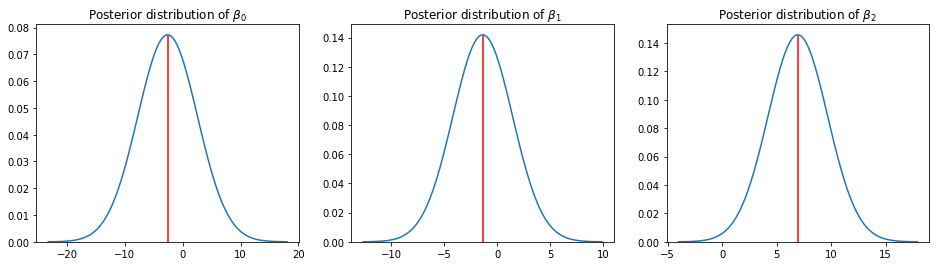

In [42]:
from scipy import stats

# Mean and Varaince of Beta_0
mean1 = m_N[0]
var1 = S_N[0, 0]

# Mean and Varaince of Beta_1
mean2 = m_N[1]
var2 = S_N[1, 1]

# Mean and Varaince of Beta_2
mean3 = m_N[2]
var3 = S_N[2, 2]

# Generating subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# Values for plot
x1_v = np.linspace(mean1-4*np.sqrt(var1), mean1+4*np.sqrt(var1), 100)
m1_h = stats.norm.pdf(mean1, mean1, np.sqrt(var1))
x2_v = np.linspace(mean2-4*np.sqrt(var2), mean2+4*np.sqrt(var2), 100)
m2_h = stats.norm.pdf(mean2, mean2, np.sqrt(var2))
x3_v = np.linspace(mean3-4*np.sqrt(var3), mean3+4*np.sqrt(var3), 100)
m3_h = stats.norm.pdf(mean3, mean3, np.sqrt(var3))

# Posterior of beta_0
ax1.plot(x1_v, stats.norm.pdf(x1_v, mean1, np.sqrt(var1)))
ax1.vlines(mean1, 0, m1_h, color='red')
ax1.tick_params(axis='both', labelsize=10)
ax1.set_title(r'Posterior distribution of $\beta_0$', fontsize=12)
ax1.set_ylim(0)

# Posterior of beta_1
ax2.plot(x2_v, stats.norm.pdf(x2_v, mean2, np.sqrt(var2)))
ax2.vlines(mean2, 0, m2_h, color='red')
ax2.tick_params(axis='both', labelsize=10)
ax2.set_title(r'Posterior distribution of $\beta_1$', fontsize=12)
ax2.set_ylim(0)

# Posterior of beta_2
ax3.plot(x3_v, stats.norm.pdf(x3_v, mean3, np.sqrt(var3)))
ax3.vlines(mean3, 0, m3_h, color='red')
ax3.tick_params(axis='both', labelsize=10)
ax3.set_title(r'Posterior distribution of $\beta_2$', fontsize=12)
ax3.set_ylim(0)

plt.plot()

The above plots show the individual posterior distribution of the parameters of the logistic regression model. The red vertical lines are the mean of the distribution (```m_N```). 

From the training, the mean and covariance of posterior distribution given the data are:

In [43]:
print(f'Mean of posterior distribution:\n {m_N}')
print(f'Covariance of posterior distribution:\n {S_N}')

Mean of posterior distribution:
 [[-2.61094422]
 [-1.3601705 ]
 [ 6.95465141]]
Covariance of posterior distribution:
 [[26.61946201 12.04766774 11.7469238 ]
 [12.04766774  7.89580383  5.55795226]
 [11.7469238   5.55795226  7.49759299]]


Now, let's evaluate trained bayesian logistic regression model using ```sklearn.metrics.classification_report```.

In [44]:
from sklearn.metrics import classification_report

print('----------------------------for training---------------------------')
print(classification_report(y_train, y_pred_train))

print('----------------------------for testing---------------------------')
print(classification_report(y_test, y_pred_test))

----------------------------for training---------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       116
           1       0.98      0.98      0.98       124

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

----------------------------for testing---------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        27

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Since the synthetic data was linearly separable the model is performing exceptionally with around 98% accuracy.  Now. let's plot the decision boundary of the model.

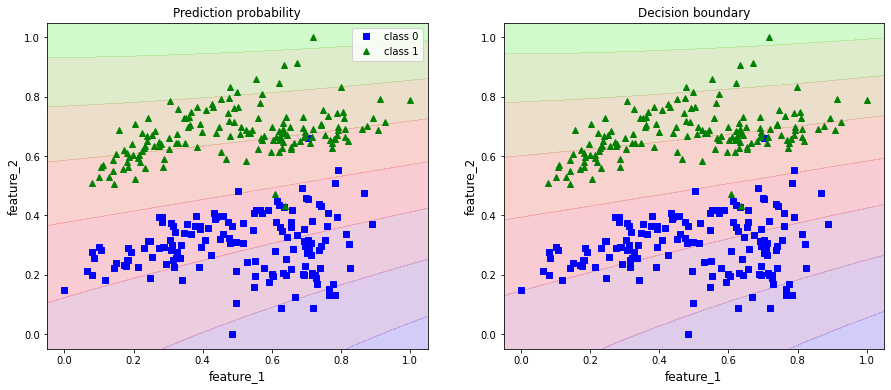

In [45]:
# Generating independent features
x1_points = np.linspace(-0.05,1.05, 1000)
x2_points = np.linspace(-0.05,1.05, 1000)

# Generating grid of values
x1,x2 = np.meshgrid(x1_points,x2_points)

# Changing dimension (Required for vectorized operations)
X_values = np.column_stack((x1.ravel(),x2.ravel()))

X_sample = np.c_[np.ones(X_values.shape[0]),X_values]

# Computing hypothesis function and prediction
y_pred = prediction(X_sample, m_N, S_N)
y_pred = y_pred.reshape(x1.shape)


# Plotting the datapoints (helps in visualization)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.plot(X_mat_pad[:,1][np.ravel(y_vec)==0], X_mat_pad[:,2][np.ravel(y_vec)==0], 'bs', label='class 0')
ax1.plot(X_mat_pad[:,1][np.ravel(y_vec)==1], X_mat_pad[:,2][np.ravel(y_vec)==1], 'g^', label='class 1')
ax1.set_xlabel(syn_df.columns[0], fontsize=12)
ax1.set_ylabel(syn_df.columns[1], fontsize=12)
ax1.set_title('Prediction probability', fontsize=12)
ax1.legend()

# Plotting the prediction probability
ax1.contourf(x1, x2, y_pred, cmap=plt.cm.brg, alpha=0.2)

# Plotting the datapoints (helps in visualization)
ax2.plot(X_mat_pad[:,1][np.ravel(y_vec)==0], X_mat_pad[:,2][np.ravel(y_vec)==0], 'bs', label='class 0')
ax2.plot(X_mat_pad[:,1][np.ravel(y_vec)==1], X_mat_pad[:,2][np.ravel(y_vec)==1], 'g^', label='class 1')
ax2.set_xlabel(syn_df.columns[0], fontsize=12)
ax2.set_ylabel(syn_df.columns[1], fontsize=12)
ax2.set_title('Decision boundary', fontsize=12)
ax1.legend()

# Plotting the prediction probability
ax2.contourf(x1, x2, np.round(y_pred), cmap=plt.cm.brg, alpha=0.2)
plt.show()

On the left side is the plot of the prediction probability, aka confidence. The confidence between region of two classes is lower(shown by red) than the confidence near the data cluster(shown by green and blue). On the right we have the decision boundary of the trained model, which as expected is a linear line separating the data.

## Why feature scaling?

We conducted feature scaling at the start of this assignment. But why? Let's train the bayesian logistic regression model with using feature scaling and see the results.

In [46]:
# Unscaled data
X_unscaled = np.c_[np.ones(X_data.shape[0]), X_data]

m_N_unscaled, S_N_unscaled = calculate_approx_params(beta_initial, X_unscaled, m_0, S_0, y_vec)

y_unscaled_pred = np.round(prediction(X_unscaled, m_N_unscaled, S_N_unscaled))

# Accuracy
print(classification_report(y_vec, y_unscaled_pred))

              precision    recall  f1-score   support

      -212.0       0.00      0.00      0.00         0
      -205.0       0.00      0.00      0.00         0
      -203.0       0.00      0.00      0.00         0
      -199.0       0.00      0.00      0.00         0
      -197.0       0.00      0.00      0.00         0
      -182.0       0.00      0.00      0.00         0
      -174.0       0.00      0.00      0.00         0
      -172.0       0.00      0.00      0.00         0
      -170.0       0.00      0.00      0.00         0
      -169.0       0.00      0.00      0.00         0
      -167.0       0.00      0.00      0.00         0
      -164.0       0.00      0.00      0.00         0
      -160.0       0.00      0.00      0.00         0
      -157.0       0.00      0.00      0.00         0
      -156.0       0.00      0.00      0.00         0
      -152.0       0.00      0.00      0.00         0
      -150.0       0.00      0.00      0.00         0
      -146.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


By using unscaled features, the accuracy has dropped from 98% to 76%. Let's check the decision boundary.

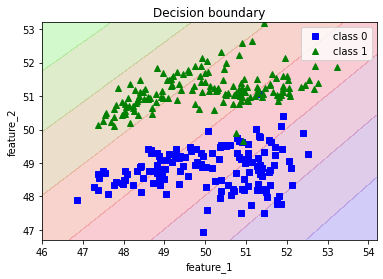

In [47]:
# Generating independent features
x1_points = np.linspace(46,54.2, 1000)
x2_points = np.linspace(46.7,53.2, 1000)

# Generating grid of values
x1,x2 = np.meshgrid(x1_points,x2_points)

# Changing dimension (Required for vectorized operations)
X_values = np.column_stack((x1.ravel(),x2.ravel()))

X_sample = np.c_[np.ones(X_values.shape[0]),X_values]

y_unscaled_pred = np.round(prediction(X_sample, m_N_unscaled, S_N_unscaled))

# Plotting the datapoints (helps in visualization)
plt.plot(X_unscaled[:,1][np.ravel(y_vec)==0], X_unscaled[:,2][np.ravel(y_vec)==0], 'bs', label='class 0')
plt.plot(X_unscaled[:,1][np.ravel(y_vec)==1], X_unscaled[:,2][np.ravel(y_vec)==1], 'g^', label='class 1')
plt.xlabel(syn_df.columns[0])
plt.ylabel(syn_df.columns[1])
plt.title('Decision boundary')
plt.legend()

# Plotting the decision boundary
plt.contourf(x1, x2, y_unscaled_pred.reshape(x1.shape), cmap=plt.cm.brg, alpha=0.2)
plt.show()

See the decision boundary is unable to separate the two classes. The BFGS algorithm that we used fails to converge due to unscaled feature, resulting in suboptimal decision boundary. Remember: your data must always be ready for any algorithm, so it is highly advised that you always scale the features. 

## Additional Resources

- Book
 - Bishop C. M. (2006), Pattern recognition and machine learning, 
   - Check Topic: Chapter 4, Section 4.4, 4.5 contains information regarding laplace approximation and bayesian logistic regression respectively.